# HW 4 - Supervised Learning at Scale. (Shishir Agarwal)
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2020`__

In the first three homeworks you became familiar with the Map-Reduce programming paradigm as manifested in the Hadoop Streaming and Spark frameworks. We explored how different data structures and design patterns can help us manage the computational complexity of an algorithm. As part of this process you implemented both a supervised learning alogorithm (Naive Bayes) and an unsupervised learning algorithm (synonym detection via cosine similarity). In both of these tasks parallelization helped us manage calculations involving a large number of features. However a large feature space isn't the only situation that might prompt us to want to parallelize a machine learning algorithm. In the final two assignments we'll look at cases where the iterative nature of an algorithm is the main driver of its computational complexity (and the reason we might want to parallelize it).

In this week's assignment we'll perform 3 kinds of linear regression: OLS, Ridge and Lasso. As in previous assignments you will implement the core calculations using Spark RDDs... though we've provided more of a code base than before since the focus of the latter half of the course is more on general machine learning concepts. By the end of this homework you should be able to:  
* ... __define__ the loss functions for OLS, Ridge and Lasso regression.
* ... __calculate__ the gradient for each of these loss functions.
* ... __identify__ which parts of the gradient descent algorithm can be parallelized.
* ... __implement__ parallelized gradient descent with cross-validation and regularization.
* ... __compare/contrast__ how L1 and L2 regularization impact model parameters & performance.

Additional Reference: [Spark 3.0.0 Documentation - RDD programming guide](https://spark.apache.org/docs/3.0.0/rdd-programming-guide.html)

__Please refer to the `README` for homework submission instructions and additional resources.__

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [0]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os

In [0]:
np.set_printoptions(precision=10, suppress=True)

### Run the next cell to create your directory in dbfs
You do not need to understand this scala snippet. It simply dynamically fetches your user directory name so that any files you write can be saved in your own directory.

In [0]:
# RUN THIS CELL AS IS
# This code snippet reads the user directory name, and stores is in a python variable.
# Next, it creates a folder inside your home folder, which you will use for files which you save inside this notebook.
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
hw4_path = userhome + "/HW4/" 
hw4_path_open = '/dbfs' + hw4_path.split(':')[-1] # for use with python open()
dbutils.fs.mkdirs(hw4_path)

dbfs:/user/shishir.agarwal@ischool.berkeley.edu
Out[3]: True

In [0]:
# RUN THIS CELL AS IS. You should see 348625. If you do not see this, please let an Instructor or TA know.
total = 0
DATA_PATH = 'dbfs:/mnt/mids-w261/HW4/'
for item in dbutils.fs.ls(DATA_PATH):
  total = total+item.size
total



Out[4]: 348625

In [0]:
# RUN THIS CELL AS IS - A test to make sure your directory is working as expected.
# You should see a result like:
# dbfs:/user/youremail@ischool.berkeley.edu/hw4/sample_docs.txt
dbutils.fs.put(hw4_path+'test.txt',"hello world",True)
display(dbutils.fs.ls(hw4_path))


Wrote 11 bytes.

path,name,size
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW4/OLSloss.csv,OLSloss.csv,2500
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW4/OLSmodels.csv,OLSmodels.csv,16492
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW4/lasso_loss.txt,lasso_loss.txt,1989
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW4/lasso_models.txt,lasso_models.txt,11250
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW4/ols_loss.txt,ols_loss.txt,1987
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW4/ols_models.txt,ols_models.txt,11250
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW4/ridge_loss.txt,ridge_loss.txt,1991
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW4/ridge_models.txt,ridge_models.txt,11250
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW4/test.txt,test.txt,11


In [0]:
sc = spark.sparkContext
spark

Out[6]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.1 
 Master 
 spark://10.99.255.28:7077 
 AppName 
 Databricks Shell

# Question 1: Opimization Theory 

As you know from w207, Gradient Descent is an iterative process that seeks to find the optimal parameters for a model given a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss. In live session 6 you discussed some of the theory behnid why gradient descent works and looked at a small example of gradient descent in the context of linear regression.

### Q1 Tasks:

* __a) short response:__ What are the first and second order conditions for convexity and why do we care about them when performing Gradient Descent?

* __b) short response:__ Explain the relationship between problem domain space and model parameter space in the context of Gradient Descent. In practice, why can't we find the optimal model by simply looking at the error surface in model parameter space?

* __c) short response:__ In the context of Gradient Descent, what is the 'learning rate' and what are the tradeoffs associated with setting this hyperparameter?

* __d) BONUS:__ In the context of OLS, what do we mean by a 'closed form solution' and why is it not scalable?

### Q1 Student Answers:
> __a)__ In optimization theory we have a multi-variable cost function that we are looking to maximize or minimize around certain constraints. The first order condition for convexity comes into play when the function is differentiable and has roots at which the gradient function goes to zero. At these points we know the function achieves a minimum or maximum. To find whether a root is a minimum or maximum we take the second order condition and determine whether the value at the those specific points is positive or negative and based on values used for 2nd order condition we determine whether it is minimum or maximum. This is very important in Gradient Descent because we use both the 1st order and 2nd order condition within the Newton/Gradient Descent method to approximate values of the parameter that take us towards a minimum or maximum of the objective function. When performing Gradient Descent we approximate the second order derative to a learning rate and experiment with this hyperparameter to ensure quick convergence to a minimum.  

> __b)__ The problem domain space and model paramter space are similar in the sense both provides a way for us to visulaize how change in model paramteres leads us to minimum or maximum of the objective function. Incase of problem domain space we fix our data represented by actual varaibles and view changes in parameters causing the change to the best fit regression line until we find the best fit line. Incase of model parameter space we view the contours representing the error loss function and changes in the model parameter leads us to a point where the loss function is minimized. As long as we are in 2-3 dimention space we are able to view the error surface and discern the minimum or maximum of the objective function but as we have more than 3 parameters we are unable to visulaize the error surface because of which we are unable to visulaize the minimum or maximum just by looking.  

> __c)__ The learnin rate is the proxy for the second derative condition for convexity. It is used to update the model parameter. If we have a large learning rate it is possible we will zig zag over the minima and perhaps overshoot the actual minimum. If the learning rate is low we may take more steps than usual converging to the minima. Thus, for a given data set one looks at number of steps it takes to converge to the minima and setup the learnig rate accoridngly. 

> __d)__ In context of OLS it is possible to solve for the optimal model parameter algebrically and this is what it means to have a closed form solution. Thus given a dataset and an objective function, and provided we have more number of data points than number of features, via matrix algebra one can find the model parameters that optimizes the loss function. Typically this requires one to take the matrix of data and features into memory and perform matrix multiplaction. This calculation is not scalable especially on large datasets with large number of features because to store the entire dataset in memory may not be possible due to sheer size and caching it to disk will not be scalable. This leads us to use gradient descent or newton method to find the minimum.

# About the Data

For the main task in this portion of the homework you will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_)

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.  Use the following cells to download the data, add a field for red/white, and split it into a test and train set.

In [0]:
headers = dbutils.fs.head(DATA_PATH + '/winequality-red.csv',200)
headers = headers.split('\n')[0]
FIELDS = ['color'] + re.sub('"', '',headers).split(';')

[Truncated to first 200 bytes]

In [0]:
FIELDS

Out[8]: ['color',
 'fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [0]:
# RUN THIS CELL AS IS. You should see winequality-red.csv and winequality-white.csv. Please contact an Instructor or TA if you do not see these two files.
dbutils.fs.ls(DATA_PATH)

Out[9]: [FileInfo(path='dbfs:/mnt/mids-w261/HW4/titanic/', name='titanic/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/HW4/winequality-red.csv', name='winequality-red.csv', size=84199),
 FileInfo(path='dbfs:/mnt/mids-w261/HW4/winequality-white.csv', name='winequality-white.csv', size=264426)]

In [0]:
# load the raw data into an RDD - RUN THIS CELL AS IS
redsRDD = sc.textFile(DATA_PATH + '/winequality-red.csv')\
            .filter(lambda x: x != headers)\
            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
whitesRDD = sc.textFile(DATA_PATH + '/winequality-white.csv')\
              .filter(lambda x: x != headers)\
              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine

In [0]:
# Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 1316 records for evaluation and assigned 5181 for training.

In [0]:
# helper function - RUN THIS CELL AS IS
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split(';'), dtype = 'float')
    features,quality = fields[:-1], fields[-1]
    return(features, quality)

In [0]:
# cache the training set - RUN THIS CELL AS IS 
trainRDDCached = trainRDD.map(parse).cache()

# Question 2: EDA

A statistician's approach to Linear Regression typically involves a series of EDA steps to examine each feature in the data and then a series of steps to test assumptions about their potential contribution to a multi-feature linear model. In particular, we'd want to look for a set of features that exhibit a likely linear relationship with the outcome variable and that are _not_ highy correlated with each other. In the context of machine learning, these considerations remain important techniques for improving model generalizability despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

In this question we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.

### Q2 Tasks:
* __a) short response:__ Run the provided code to sample 1000 points and visualize histograms of each feature. Comment on the distributions you observe (eg. _Which features appear normaly distributed, which don't? Which features vary most/least?_) How is the varaible `color` different than the other features & what does that mean about how we interpret its regression coefficient?

* __b) short response:__ Run the provided code to create boxplots of each feature. Which, if any, appear to have a positive linear relationship with `quality`? Which if any appear to have a negative linear relationship with `quality`?


* __c) short response:__ Run the provided code to plot the correlations matrix. Which pairs of features are most _strongly_ (postively or negatively) associated with each other? What implications would that have for our feature selection?

### Q2 Student Answers:
> __a)__ __pH__ appears most normally distributed. The other features like __density__, __fixed_acidity__, __citric_acid__ are near normal. Also, __pH__, __chlorides__, __sulphates__ do not vary much while __free_sulphur_dioxide__, __total_sulphur_dioxide__, and __residual_sugar__ varies much more. Thus when conducting our analysis we want to consider transforming variables that are not normal. Also, we want to consider variables that vary as opposed to ones that do not vary. The variable __color__ is a categorical binary variable representing white wine for 0 and red wine for 1. What coefficient for __color__ will tell us is on average how much red wine contributes to quality more than white wine with all other variables remaining constant.

> __b)__ __alcohol__ seems to have positive linear relationship while __volatile_acidity__ seems to have negative linear relationship

> __c)__ __free_sulphur_dioxide__ and __total_sulphur_dioxide__ seems highly positively co-related. __density__ and __alcohol__ seems highly negatively co-related. It just means if we choose one of the highly corelated features in our analysis we will capture the variance.

In [0]:
# part a - take a 1000 point sample for EDA (RUN THIS CELL AS IS)
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)
sample_df

Out[14]:

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,6.4,0.64,0.21,1.8,0.081,14.0,31.0,0.99689,3.59,0.66,9.8,5.0
1,0.0,7.9,0.18,0.49,5.2,0.051,36.0,157.0,0.99530,3.18,0.48,10.6,6.0
2,0.0,6.3,0.26,0.24,7.2,0.039,38.0,172.0,0.99580,3.49,0.64,9.7,6.0
3,0.0,6.6,0.29,0.29,1.8,0.036,38.0,102.0,0.98819,3.08,0.42,13.7,7.0
4,1.0,9.6,0.77,0.12,2.9,0.082,30.0,74.0,0.99865,3.30,0.64,10.4,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,8.1,0.50,0.47,1.1,0.037,23.0,126.0,0.99380,3.21,0.42,10.9,5.0
996,0.0,6.3,0.20,0.30,5.9,0.034,35.0,152.0,0.99642,3.47,0.40,8.5,6.0
997,1.0,6.8,0.62,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6.0
998,1.0,6.9,0.63,0.01,2.4,0.076,14.0,39.0,0.99522,3.34,0.53,10.8,6.0


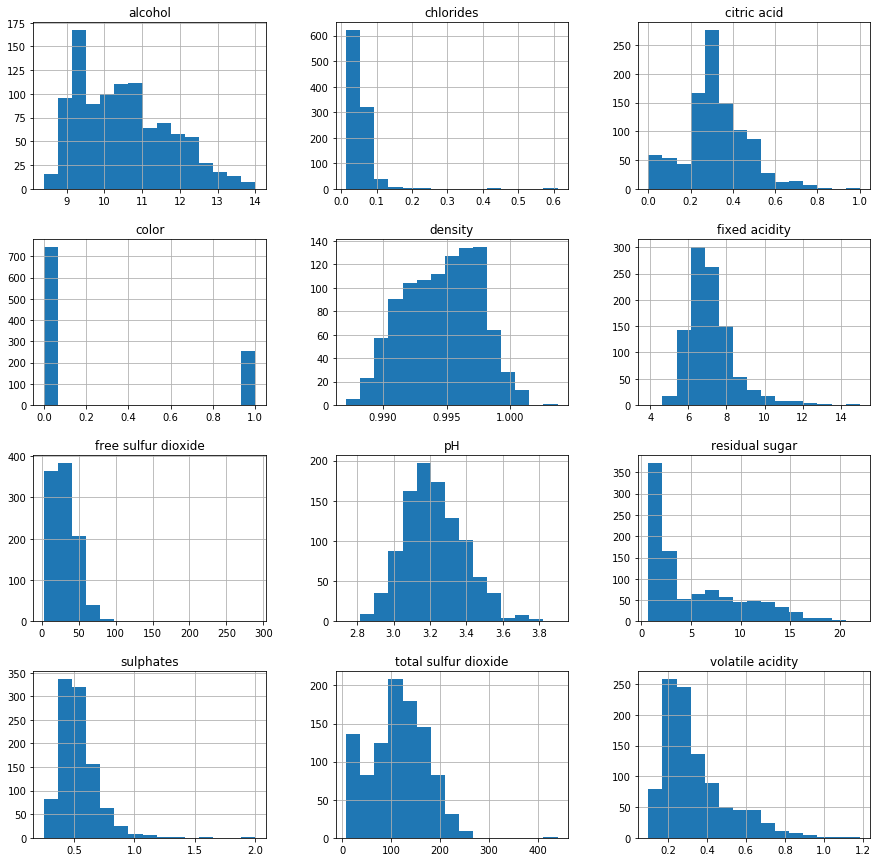

In [0]:
# part a - take a look at histograms for each feature (RUN THIS CELL AS IS)
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
display(plt.show())

In [0]:
type(FIELDS)

Out[18]: list

In [0]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 color 1000 non-null float64
 1 fixed acidity 1000 non-null float64
 2 volatile acidity 1000 non-null float64
 3 citric acid 1000 non-null float64
 4 residual sugar 1000 non-null float64
 5 chlorides 1000 non-null float64
 6 free sulfur dioxide 1000 non-null float64
 7 total sulfur dioxide 1000 non-null float64
 8 density 1000 non-null float64
 9 pH 1000 non-null float64
 10 sulphates 1000 non-null float64
 11 alcohol 1000 non-null float64
 12 quality 1000 non-null float64
dtypes: float64(13)
memory usage: 101.7 KB

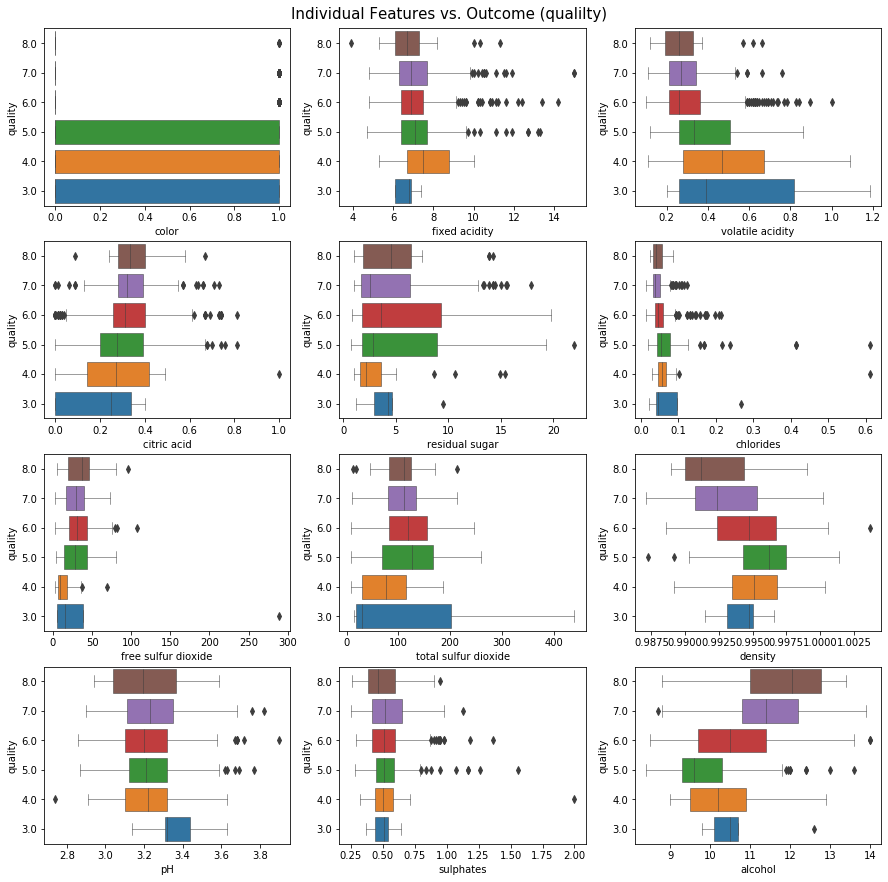

In [0]:
# part b -  plot boxplots of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))
y = sample_df['quality']
for idx, feature in enumerate(FIELDS[:-1]):
    #print(idx, feature, idx//3, idx%3 )
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
display(plt.show())

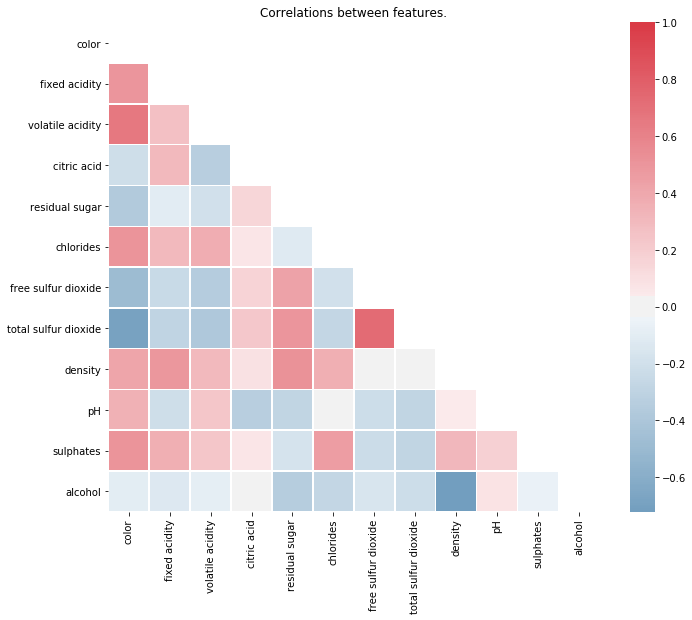

In [0]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
display(plt.show())

# Question 3: OLS Loss

For a parametric model, the key factor that will impact how easy it is to optimize is your choice of how to define the loss function. In Ordinary Least Squares (OLS) Regression our loss function is just about as convenient as you will get: not only is it convex, its also very easy to interpret. 

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. It is useful as a simple baseline to compare with other (real) regressors. Examples of regression baselines include:
* "mean": always predicts the mean of the training set
* "median": always predicts the median of the training set
* "quantile": always predicts a specified quantile of the training set,provided with the quantile parameter.
* "constant": always predicts a constant value that is provided by the user.

In this question you'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. You'll reuse this function in Q4 when you implement gradient descent.

#### Baseline example illustrated:

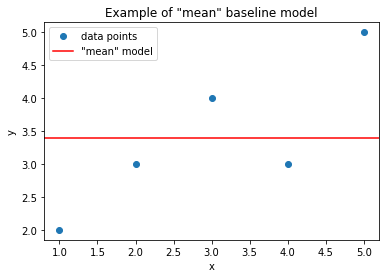

In [0]:
# points from our mini example from the demo 6 notebook
points = np.array([[1,2],[3,4],[5,5],[4,3],[2,3]])
x = points[:,0]
y = points[:,1]

plt.figure()
plt.plot(x, y,'o', label='data points')
plt.axhline(np.mean(y),c='r', label='"mean" model')
plt.title('Example of "mean" baseline model')
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
display(plt.show())

### Q3 Tasks:
* __a) code:__ Fill in the code below to compute the mean and variance of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]


* __b) short response:__ Write the formula for the OLS loss function and explain how to interpret it graphically.


* __c) short response:__ In the context of linear models & vector computations what does it mean to 'augment' a data point and why do we do this?


* __d) code + short response:__ Fill in the missing code to complete the`OLSLoss` function. Is computing the loss "embarassingly parallel'? Explain. [__`TIP:`__ Use `augmentedData` as your input when computing the loss.]

* __e) code + short response:__ Fill in the missing code to define a baseline model for this data set that has a bias term equal to the mean of your outcome variable and `0.0` for all coefficients. Note that in the docstring for `OLSLoss` we specified that the model should be a numpy array with the bias in the first position. Once you've defined your model, run the provided cells to check that your model has the correct dimensions and then compute the loss for your baseline model. Compare your results to the result you got in `part a` and explain what you see.

### Q3 Student Answers:
> __b)__ The formula for loss funtion is below: 
$$
\mathbf{x}' := \begin{bmatrix} \mathbf{x} \\\ 1 \end{bmatrix} , \quad \boldsymbol{\theta} := \begin{bmatrix} \mathbf{w} \\\ b \end{bmatrix}
$$

$$
f(\boldsymbol{\theta}) = \frac{1}{n}\sum\_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'\_i - y\_i\right]^2  \ \ \ \ \ \ 
$$

Graphically the loss function is the average of Eucledian distance between all observed and predicted data points or average of perpendicular distance from each data point onto the hyperplane represented by the model parameters.

> __c)__ We augment the data point because it allows us to add the bias terms within the vector computation upfront so we do not have to calculate the bias term seperately or in a different pass over the data. What we mean by augmenting the vector is we break the bias term into a wt value and a unit vector. The wt value is added to the wt vector while the unit vector is added as a additional columun in the data set. Thus we augment both the weight vector as well as the feauture vector. By using this technique, we are able to perform all the calculation of weight vector and the bias term all together within 1 pass over the data. 

> __d)__ Yes computing the OLS loss is embarassingly parallel because we just use the map function to compute OLS loss for each data point and then we calculate the mean at the end of the embarringly parallel task. The map function can be distributed across different machines without any dependency between one another. Thus error from each record can be computed in parallel without dependency with another record. All the error terms can then be collected to calculate the overall mean.

> __e)__ The base line model is same as the variance of the output variable. This is same because for our baseline model we assume all the coefficients to be zero and we consider bias term to be mean of all the output value. Thus when we calculate the loss using the formula above, we are essentially taking the output varaible (quality), subtracting it with the mean value (our baseline mean) and squaring it and taking an average which is same as calculating the variance of the output varaible.

In [0]:
# part a - mean and variance of the outcome variable 
meanQuality = trainRDDCached.map(lambda x: x[1]).mean() # FILL IN YOUR CODE HERE
varQuality = trainRDDCached.map(lambda x: x[1]).variance() # FILL IN YOUR CODE HERE
print(f"Mean: {meanQuality}")
print(f"Variance: {varQuality}")

Mean: 5.811040339702759
Variance: 0.760086564865664

In [0]:
# part d - write function to compute loss (FILL IN MISSING CODE BELOW)
def OLSLoss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    W = sc.broadcast(W)
    lossRDD = augmentedData.map(lambda x: (W.value.dot(x[0].T) - x[1])**2)
    loss = lossRDD.mean()
    ################## (END) YOUR CODE ##################
    return loss

In [0]:
# Test OLSLoss function
testRDD = trainRDDCached
testRDD = trainRDDCached.sample(False,0.0005,1)
print(testRDD.collect())
print(testRDD.map(lambda x: x[1]).mean())
print(testRDD.map(lambda x: x[1]).variance())
print(testRDD.count())
W = np.array([5.333333333333333,0,0,0,0,0,0,0,0,0,0,0,0])
OLSLoss(testRDD,W)

[(array([ 1. , 7. , 0.62 , 0.1 , 1.4 , 0.071, 27. , 63. ,
 0.996, 3.28 , 0.61 , 9.2 ]), 5.0), (array([ 0. , 7.2 , 0.29 , 0.2 , 7.7 , 0.046 ,
 51. , 174. , 0.99582, 3.16 , 0.52 , 9.5 ]), 5.0), (array([ 0. , 6.2 , 0.22 , 0.28 , 2.2 , 0.04 ,
 24. , 125. , 0.9917, 3.19 , 0.48 , 10.5 ]), 6.0)]
5.333333333333333
0.2222222222222222
3
Out[137]: 0.22222222222222224

In [0]:
# part e - define your baseline model here
BASELINE = np.array([meanQuality,0,0,0,0,0,0,0,0,0,0,0,0])

In [0]:
# part e - compute the loss for your baseline model (RUN THIS CELL AS IS)
assert len(BASELINE) == len(trainRDDCached.take(1)[0][0]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {OLSLoss(trainRDDCached, BASELINE)}")

Baseline model loss: 0.7600865648656636

# Question 4: Vanilla Gradient Descent

Performing Gradient Descent technically only requires two steps: 1) _use the current model to calculate the gradient_; 2) _use the gradient to update the current model parameters_. In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if its working. In this question you'll implement gradient descent for OLS regression and take a look at a few update steps.

### Q4 Tasks:
* __a) short response:__ Jimi describes the main part of the gradient calculation for OLS Regression using a short mantra: _'the mean of the data weighted by the errors'_. . Write the formula for the gradient and explain how it reflects this phrase. 

* __b) short response:__ Looking at the formula you wrote in `part a`, what parts of this calculation can be parallelized and what has to happen after reducing?


* __c) code:__ Fill in the missing lines in `GDUpdate` to compute the gradient and perform a single update of the model parameters.   
    * __`TIP 1:`__ _remember that the gradient is a vector of partial derivatives, `grad` should be a numpy array_    
    * __`TIP 2:`__ _Spark's built in `mean()` function may help you here_  


* __d) short response:__ Run the provided code to perform 5 steps of Gradient Descent on our data. What is wrong with these results?


* __e) code + short response:__ Fill in the missing code in `normalize` so that this function scales each feature and centers it at 0. Then use the provide code block to rerun your same gradient descent code on the scaled data. Use these results to explain what the problem was in 'd'.
    * __`TIP:`__ _You may find [this brief illustration](https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-i-feature-scaling-xx3Da) from Andrew Ng's Coursera helpful._

### Q4 Student Answers:
> __a)__ The equation of the gradient is:

$$
\mathbf{x}' := \begin{bmatrix} \mathbf{x} \\\ 1 \end{bmatrix} , \quad \boldsymbol{\theta} := \begin{bmatrix} \mathbf{w} \\\ b \end{bmatrix}
$$

$$
\nabla\_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum\_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'\_i - y_i\right] \cdot \mathbf{x}'\_i  \ \ \ \ \ \ 
$$

The following is the error term.

$$ \left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'\_i - y_i\right] $$ 

We take a dot product of error term with each data point which provides "data weighted by the errors"

$$ \sum\_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'\_i - y_i\right] \cdot \mathbf{x} $$

We then take the mean which is "the mean of the data weighted by the errors"

$$
\frac{1}{n}\,\sum\_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'\_i - y_i\right] \cdot \mathbf{x}'\_i  \ \ \ \ \ \ 
$$


> __b)__ The calculation of the error term and the dot product with the data can be parallelized. After reducing (taking the mean) we need to multiply the value with the learning rate (proxy for the second derative) and use the results to update the model parameters. 

> __c)__ _complete the coding portions of this question before answering d & e_ 

> __d)__ What we notice is with every step we are increasing the total loss and it feels like we are moving away from our minimum point. It just means we do not know what is the right direction and may have to try many more steps before converging to the minimum.  

> __e)__ When we feature scale or normalize the data the loss contours are not skewed which allows Gradient Decsent to converge quickly to the local minimum. We notice with every step we reduce the loss and march towards our minimum.

In [0]:
# part b - function to perform a single GD step
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    ################## YOUR CODE HERE ################# 
    initial_model = sc.broadcast(W)
    grad = augmentedData.map(lambda x: (x[0].dot(initial_model.value.dot(x[0].T) - x[1]),1)) \
                        .reduce(lambda a,b: (np.array(a[0])+np.array(b[0]), int(a[1])+int(b[1])))
    update = grad[0].dot(learningRate*2/grad[1])
    new_model = W - update
    ################## (END) YOUR CODE ################# 
    return new_model

In [0]:
# Test GDUpdate function
testRDD = trainRDDCached
testRDD = trainRDDCached.sample(False,0.0005,1)
print(testRDD.collect())
print(testRDD.map(lambda x: x[1]).mean())
print(testRDD.map(lambda x: x[1]).variance())
print(testRDD.count())
W = np.array([1,0,0,0,0,0,0,0,0,0,0,0,0])
GDUpdate(testRDD,W)

[(array([ 1. , 7. , 0.62 , 0.1 , 1.4 , 0.071, 27. , 63. ,
 0.996, 3.28 , 0.61 , 9.2 ]), 5.0), (array([ 0. , 7.2 , 0.29 , 0.2 , 7.7 , 0.046 ,
 51. , 174. , 0.99582, 3.16 , 0.52 , 9.5 ]), 5.0), (array([ 0. , 6.2 , 0.22 , 0.28 , 2.2 , 0.04 ,
 24. , 125. , 0.9917, 3.19 , 0.48 , 10.5 ]), 6.0)]
5.333333333333333
0.2222222222222222
3
Out[141]: array([ 1.8666666667, 0.2666666667, 5.8533333333, 0.316 ,
 0.1733333333, 3.16 , 0.0445333333, 28.8 ,
 104.8666666667, 0.8617186667, 2.7806666667, 0.4613333333,
 8.4866666667])

In [0]:
%%time
# part c - take a look at a few Gradient Descent steps (RUN THIS CELL AS IS)

nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(trainRDDCached, model)
    loss = OLSLoss(trainRDDCached, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE: Loss = 0.7600865648656636
----------
STEP: 1
Loss: 3255.0397706647977
Model: [5.811, -0.009, -0.017, -0.007, 0.002, -0.035, -0.001, 0.167, -0.489, -0.0, 0.0, 0.001, 0.094]
----------
STEP: 2
Loss: 41538896320.90039
Model: [15.998, 0.946, 71.311, 3.109, 3.394, 67.104, 0.517, 372.213, 1469.681, 10.133, 32.587, 5.197, 105.407]
----------
STEP: 3
Loss: 5.3215162542469203e+17
Model: [-36732.224, -3790.819, -257459.013, -11294.195, -12193.785, -240557.886, -1880.28, -1359608.579, -5252902.327, -36544.479, -117571.505, -18781.008, -379946.295]
----------
STEP: 4
Loss: 6.817355374095383e+24
Model: [131498780.95, 13574790.866, 921540888.277, 40426173.604, 43645471.549, 861027822.897, 6730358.366, 4867148463.848, 18801163135.814, 130805962.538, 420832007.136, 67225003.981, 1359973545.811]
----------
STEP: 5
Loss: 8.73366388015958e+31
Model: [-470665198626.59, -48587550191.149, -3298412689019.922, -144694834630.26, -156217444459.899, -3081821742976.576, -24089547803.278, -17420693064591.162, -67293783870862.445, -468185458548.501, -1506257249668.984, -240614204453.624, -4867666956412.443]
CPU times: user 112 ms, sys: 8 ms, total: 120 ms
Wall time: 1.15 s

In [0]:
# part d - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    ################ YOUR CODE HERE #############
    normedRDD = dataRDD.map(lambda x: ((x[0]-featureMeans)/featureStdev,x[1]))
    ################ FILL IN YOUR CODE HERE #############
    return normedRDD

In [0]:
# Test normalize function
testRDD = trainRDDCached
testRDD = trainRDDCached.sample(False,0.0005,1)
print(testRDD.collect())
print(testRDD.map(lambda x: x[1]).mean())
print(testRDD.map(lambda x: x[1]).variance())
print(testRDD.count())
normalize(testRDD).collect()

[(array([ 1. , 7. , 0.62 , 0.1 , 1.4 , 0.071, 27. , 63. ,
 0.996, 3.28 , 0.61 , 9.2 ]), 5.0), (array([ 0. , 7.2 , 0.29 , 0.2 , 7.7 , 0.046 ,
 51. , 174. , 0.99582, 3.16 , 0.52 , 9.5 ]), 5.0), (array([ 0. , 6.2 , 0.22 , 0.28 , 2.2 , 0.04 ,
 24. , 125. , 0.9917, 3.19 , 0.48 , 10.5 ]), 6.0)]
5.333333333333333
0.2222222222222222
3
Out[144]: [(array([ 1.4142135624, 0.4629100499, 1.3951025683, -1.2675004446,
 -0.8451183307, 1.390473134 , -0.579324122 , -1.2696585163,
 0.7519403881, 1.372812946 , 1.3489065469, -0.9596162302]),
 5.0),
 (array([-0.7071067812, 0.9258200998, -0.4968858462, 0.090535746 ,
 1.4045628595, -0.4717676705, 1.4069300106, 1.1742506509,
 0.6613047163, -0.9805806757, -0.3065696697, -0.4198321007]),
 5.0),
 (array([-0.7071067812, -1.3887301497, -0.898216722 , 1.1769646986,
 -0.5594445288, -0.9187054635, -0.8276058886, 0.0954078654,
 -1.4132451044, -0.3922322703, -1.0423368771, 1.379448331 ]),
 6.0)]

In [0]:
# part d - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(trainRDDCached).cache()

In [0]:
%%time
# part e - take a look at a few GD steps w/ normalized data  (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD, model)
    loss = OLSLoss(normedRDD, model) 
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE: Loss = 0.7600865648656636
----------
STEP: 1
Loss: 0.655527669170389
Model: [5.811, -0.02, -0.014, -0.045, 0.014, -0.007, -0.035, 0.009, -0.009, -0.054, 0.003, 0.008, 0.078]
----------
STEP: 2
Loss: 0.615059239044261
Model: [5.811, -0.022, -0.014, -0.071, 0.023, -0.006, -0.05, 0.014, -0.021, -0.079, 0.007, 0.024, 0.131]
----------
STEP: 3
Loss: 0.5935522582531458
Model: [5.811, -0.018, -0.01, -0.09, 0.03, 0.002, -0.057, 0.02, -0.032, -0.09, 0.011, 0.04, 0.167]
----------
STEP: 4
Loss: 0.5798853360580277
Model: [5.811, -0.014, -0.006, -0.105, 0.034, 0.012, -0.061, 0.026, -0.04, -0.094, 0.013, 0.054, 0.195]
----------
STEP: 5
Loss: 0.5703196233260643
Model: [5.811, -0.009, -0.003, -0.117, 0.036, 0.024, -0.063, 0.032, -0.047, -0.096, 0.016, 0.066, 0.217]
CPU times: user 108 ms, sys: 16 ms, total: 124 ms
Wall time: 1.27 s

# Question 5: Assessing the performance of your model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but this number doesn't accurately reflect "how good" our model is. In this question you'll plot error curves for a test and training set in order to discuss model performance. Note that although we split out a test & train set when we first loaded the data... in the spirit of keeping that 20% truly 'held out' until then end of the assignment, we'll make an additional split for the purposes of this question dividing the existing training set into two smaller RDDs.

### Q5 Tasks:
* __a) short response:__ Why doesn't the loss that we printed in Question 4 accurately reflect "how good" our model is? 


* __b) code:__ Since we're going to be running Gradient Descent a number of times let's package it into a function for convenience. Fill in the missing code in `GradientDescent()`, note that the missing code is going to look a lot like the provided code blocks in Q5 -- feel free to use those as a starting point.


* __c) short response:__ Use the provided code to split the normalized data into a test and train set, then run 50 iterations of gradient descent and plot the MSE curves for each. Describe what you see and speculate about why this might be happening.


* __d) short response:__ Note that passing the optional parameter `seed` to the Spark method `randomSplit` allows us to pseudo randomize our test/train split in a way that is replicable. Re-run the code for part 'c but this time in the line where we perform the `normedRDD.randomSplit` change the seed to _`seed = 5`_. What changes in the plot? Repeat for _`seed = 4`_. How does this change your interpret the results you saw in 'c'. What is the more likely explanation?

### Q5 Student Answers:
> __a)__ The loss we print in Q#4 is calculated on the training data. This does not indicate how our model will perform on unseen test data. We could have perfect overfitting model on the training data which will yield low loss however that loss may get very high on test data. Thus to know how our model will perform we have to claculate the loss on the test data to assess how our model performs on unseen data.  

> __c)__ We notice the loss on test data is always worse than training data. This is expected because model was fitted using the training data and in general when we try the model on test data it yields a loss worse because there are data points in the test data that the model has not seen before. 

> __d)__ When we use a different seed we get a different loss results. When we use __seed = 5__ the loss between training and test data is similar. WHen we use __seed = 4__ the loss between the training and test data widens and shows non-intuitive where loss on training data is more than loss on test data. This is purely by chance and how the data gets split into test and train data. If the data is split in such a way that test and train data are similar then we will see very little difference in their loss. However if the data gets split in such a way where there are unseen data points or outliers in test data not seen in training data, then we see the loss widen between train data set and test data set. Thus we will see such variance in model performance based on how we split the data.

In [0]:
# part b - OLS gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        #model = None
        model = GDUpdate(trainRDD, model)
        #training_loss = None
        training_loss = OLSLoss(trainRDD, model) 
        #test_loss = None
        test_loss = OLSLoss(testRDD, model) 
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [0]:
# plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    display(plt.show())

In [0]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50, verbose=True)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.652038520601051
test loss: 0.6764193185747347
Model: [5.809, -0.019, -0.012, -0.044, 0.013, -0.008, -0.034, 0.009, -0.009, -0.052, 0.003, 0.007, 0.077]
----------
STEP: 2
training loss: 0.6123045885481087
test loss: 0.6319819288651607
Model: [5.807, -0.02, -0.012, -0.071, 0.022, -0.007, -0.049, 0.015, -0.022, -0.076, 0.008, 0.022, 0.129]
----------
STEP: 3
training loss: 0.5910888319085906
test loss: 0.6083363372407662
Model: [5.806, -0.017, -0.007, -0.09, 0.028, -0.0, -0.056, 0.02, -0.032, -0.088, 0.011, 0.038, 0.165]
----------
STEP: 4
training loss: 0.5776169189494935
test loss: 0.5933067530960826
Model: [5.805, -0.012, -0.003, -0.106, 0.031, 0.009, -0.06, 0.027, -0.041, -0.092, 0.014, 0.051, 0.193]
----------
STEP: 5
training loss: 0.5681876824273763
test loss: 0.5827601859414377
Model: [5.804, -0.007, 0.001, -0.118, 0.033, 0.02, -0.062, 0.033, -0.048, -0.094, 0.016, 0.063, 0.215]
----------
STEP: 6
training loss: 0.5612204547516104
test loss: 0.5749533724028834
Model: [5.804, -0.002, 0.005, -0.129, 0.033, 0.031, -0.063, 0.039, -0.054, -0.094, 0.018, 0.072, 0.232]
----------
STEP: 7
training loss: 0.5559043231063925
test loss: 0.568996452138209
Model: [5.803, 0.002, 0.008, -0.138, 0.032, 0.042, -0.064, 0.045, -0.059, -0.093, 0.02, 0.079, 0.247]
----------
STEP: 8
training loss: 0.5517622742015557
test loss: 0.5643642711559163
Model: [5.803, 0.007, 0.01, -0.146, 0.03, 0.052, -0.064, 0.051, -0.064, -0.092, 0.022, 0.085, 0.259]
----------
STEP: 9
training loss: 0.5484867303984134
test loss: 0.5607153730037164
Model: [5.803, 0.011, 0.012, -0.153, 0.028, 0.061, -0.064, 0.055, -0.068, -0.091, 0.023, 0.09, 0.27]
----------
STEP: 10
training loss: 0.5458670289851426
test loss: 0.5578135301669911
Model: [5.803, 0.015, 0.014, -0.16, 0.026, 0.069, -0.064, 0.06, -0.072, -0.09, 0.025, 0.094, 0.28]
----------
STEP: 11
training loss: 0.5437528411201575
test loss: 0.5554885523268541
Model: [5.802, 0.018, 0.015, -0.165, 0.023, 0.077, -0.064, 0.064, -0.076, -0.089, 0.026, 0.097, 0.288]
----------
STEP: 12
training loss: 0.542033712483839
test loss: 0.5536143870023736
Model: [5.802, 0.022, 0.017, -0.171, 0.021, 0.084, -0.063, 0.068, -0.079, -0.088, 0.027, 0.099, 0.295]
----------
STEP: 13
training loss: 0.5406267122961715
test loss: 0.5520958136422295
Model: [5.802, 0.025, 0.018, -0.176, 0.018, 0.091, -0.063, 0.071, -0.082, -0.088, 0.027, 0.101, 0.301]
----------
STEP: 14
training loss: 0.5394685357548512
test loss: 0.5508598412104933
Model: [5.802, 0.028, 0.019, -0.18, 0.016, 0.096, -0.062, 0.074, -0.085, -0.087, 0.028, 0.103, 0.307]
----------
STEP: 15
training loss: 0.5385102241348552
test loss: 0.5498498818302252
Model: [5.802, 0.03, 0.02, -0.184, 0.013, 0.102, -0.061, 0.077, -0.088, -0.087, 0.029, 0.104, 0.312]
----------
STEP: 16
training loss: 0.537713509187323
test loss: 0.5490216636063179
Model: [5.802, 0.033, 0.021, -0.188, 0.011, 0.107, -0.06, 0.079, -0.09, -0.087, 0.029, 0.104, 0.316]
----------
STEP: 17
training loss: 0.5370482112722044
test loss: 0.5483402862305147
Model: [5.802, 0.035, 0.022, -0.192, 0.009, 0.111, -0.059, 0.081, -0.092, -0.087, 0.029, 0.105, 0.32]
----------
STEP: 18
training loss: 0.5364903466060862
test loss: 0.5477780565176223
Model: [5.802, 0.038, 0.022, -0.195, 0.007, 0.115, -0.058, 0.083, -0.094, -0.087, 0.03, 0.105, 0.323]
----------
STEP: 19
training loss: 0.536020726222122
test loss: 0.5473128723376912
Model: [5.802, 0.04, 0.023, -0.198, 0.005, 0.119, -0.058, 0.085, -0.096, -0.087, 0.03, 0.106, 0.326]
----------
STEP: 20
training loss: 0.5356239042494841
test loss: 0.5469270011813773
Model: [5.802, 0.042, 0.024, -0.201, 0.003, 0.122, -0.057, 0.087, -0.098, -0.087, 0.03, 0.106, 0.329]
----------
STEP: 21
training loss: 0.5352873792405506
test loss: 0.5466061478536687
Model: [5.802, 0.044, 0.024, -0.204, 0.001, 0.125, -0.056, 0.089, -0.1, -0.087, 0.03, 0.106, 0.331]
----------
STEP: 22
training loss: 0.535000981719957
test loss: 0.5463387369898272
Model: [5.802, 0.046

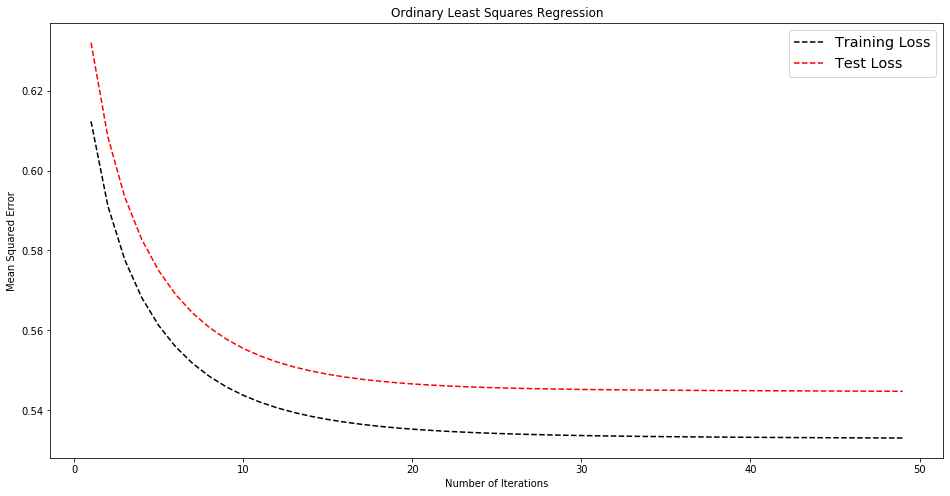

In [0]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [0]:
# save the models & their performance for comparison later (RUN THIS CELL AS IS)
np.savetxt(hw4_path_open + 'OLSmodels.csv', np.array(models), delimiter=',')
np.savetxt(hw4_path_open + 'OLSloss.csv', np.array([MSEtrain, MSEtest]), delimiter=',')

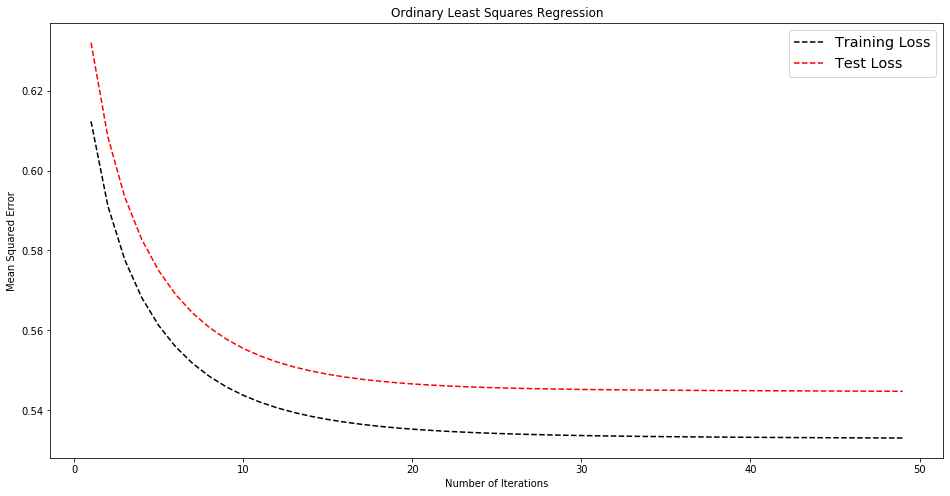

In [0]:
# take a look (RUN THIS CELL AS IS)
dbutils.fs.put(hw4_path + 'ols_models.txt', str(models), True)
dbutils.fs.put(hw4_path + 'ols_loss.txt', str([MSEtrain, MSEtest]), True)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [0]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

... trained 50 iterations in 13.759857177734375 seconds

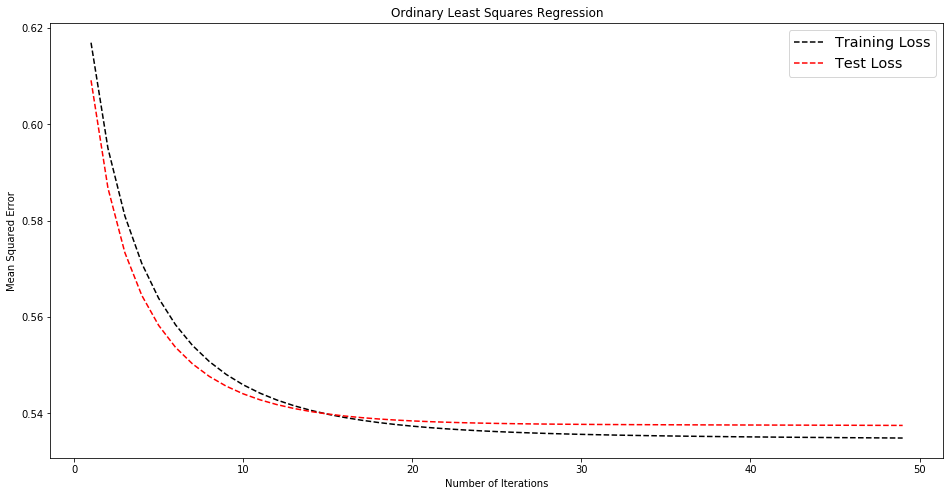

In [0]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [0]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 4)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

... trained 50 iterations in 13.943877935409546 seconds

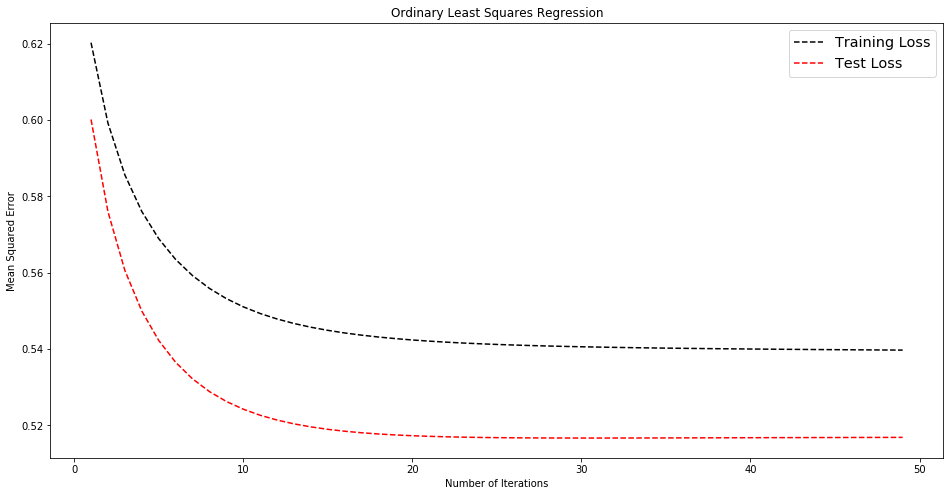

In [0]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

# Question 6: Cross Validation

In question 5 we mentioned that computing the loss after each iteration is not strictly a part of Gradient Descent, its just convenient for visualizing our progress. This "third step" however comes with a tradeoff: it requires an extra pass through the data. Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place no shuffle needed for the aggregation. 

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) , sometimes called rotation estimation, or out-of-sample testing, is a model validation technique for assessing how well the model will generalize to an independent data set. The goal of cross-validation is to test the model's ability to predict new data. 

Cross validation, which will solve the problem of the unreliable test-loss that we saw in question 5, presents a bit more of a scalability challenge. To avoid over-dependence on a particulary good or bad test/train split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the test/train loss for each model. In this question we've provided a code base to perform gradient descent and cross validation in parallel. You'll fill in some of the key details based on your understanding from questions 1-5.

#### From ISLR Chapter 5.1 - Cross Validation
<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/CV-ISLRp181.png?raw=true">


### Q6 Tasks:
* __a) short response:__ A naive approach to training an OLS Regression model with cross validation might be to simply perform Gradient Descent on each of the 5 models in sequence. In this naive approach, how many total passes would be made over the data? [__`HINT:`__ _it will depend on factors that you should be able to name._]


* __b) short response:__ Read through the provided helper function `kResiduals()` and note where it gets used in the subsequent function `CVLoss()`. For each record in the original dataset, how many tuples does `kResiduals()` emit? What are the keys of these newly emitted records? How will these keys help us compute cross validated loss?


* __c) code:__ Complete the missing Spark code in `CVLoss()` so that this function returns the test/train cross validated error for a given set of data splits and their corresponding models. [__`TIP:`__ _your goal is to start from `partialLossRDD` and compute the test & train loss for each model so that the provided code can take the final average_].


* __d) code:__ Read through the provided functions `partialGradients()` and `CVUpdate()`. These should have a familiar feel. Fill in the missing line in `CVUpdate()` to update each model and add the (new) array of coefficients to the `new_models` list. 


* __e) short response:__ Read `GradientDescent_withCV()` and then run the provided code to perform 50 iterations and plot the error curves. What can you conclude from this graph?

### Q6 Student Answers:
> __a)__ In the naive approach we will pass through the data __k__ times which is __5__ times in this example

> __b)__ For each record we emit __k__ tuples. The key consists of __(0-test, 1-test, 2-test, 3-test, 4-test, 0-train, 1-train, 2-train, 3-train, 4-train)__. These keys let us calculate the train and test loss for example by reducing/aggregating keys from same model within a single partition. Thus keys from __(0-test, 0-train)__ are aggregated to calculate loss on training and test data for __model0__. This approach requires only 1-pass compared to k passes in naive approach.

> __e)__ In Q5 we saw some variations in model performance depending how data is split. But using the CV technique we conclude on average (or in the long run) we will have our training model fit the test data quite perfectly.

In [0]:
# part b - helper function to emit residuals (RUN THIS CELL AS IS)
def kResiduals(dataPoint, models, splitNum):
    """
    Compute the (squared) residuals for a data point given k different models.
    Note that points from the k-th split are part of the test set for model number k
    and part of the training set for all other models. We'll emit a key to track this.
    Args:
        dataPoint - tuple of (features_array, y)
        models    - list of arrays representing model weights (bias at index 0)
    Returns:
        (stringFormattedKey, squared_error)
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit squared residuals for each model
    for modelNum, W in enumerate(models):
        if modelNum == splitNum:
            yield(f"{modelNum}-test", (W.dot(X) - y)**2)
        else:
            yield(f"{modelNum}-train", (W.dot(X) - y)**2)

In [0]:
# Test normalize function
testRDD = trainRDDCached
testRDD = trainRDDCached.sample(False,0.00155,1)
#print(testRDD.collect())
print(testRDD.map(lambda x: x[1]).mean())
print(testRDD.map(lambda x: x[1]).variance())
print(testRDD.count())
testRDD_combine = testRDD.map(lambda x: np.append(x[0], [x[1]])).collect()
testRDD_df = pd.DataFrame(testRDD_combine, columns = FIELDS)
dataSplits = testRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
bModels = [BASELINE] * len(dataSplits)
print(dataSplits[2].count())
bModels

5.6
0.44000000000000006
10
2
Out[158]: [array([5.8110403397, 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. ]),
 array([5.8110403397, 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. ]),
 array([5.8110403397, 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. ]),
 array([5.8110403397, 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. ]),
 array([5.8110403397, 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. ])]

In [0]:
partialLossRDD = sc.parallelize([])
for splitNum, splitRDD in enumerate(dataSplits):
  residuals = splitRDD.flatMap(lambda x: kResiduals(x, bModels, splitNum))
  partialLossRDD = sc.union([partialLossRDD, residuals])
  print(splitNum, residuals.count(), partialLossRDD.count())
partialLossRDD.count()
loss = partialLossRDD.collect()
test_loss = [x[1] for x in loss if x[0].split('-')[1] == 'test']
training_loss = [x[1] for x in loss if x[0].split('-')[1] == 'train']

0 10 10
1 15 25
2 10 35
3 10 45
4 5 50

In [0]:
# part c - fill in the missing code below
def CVLoss(dataSplits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    Args:
        dataSplits - list of RDDs corresponding to the k test splits.
        models     - list of k arrays representing model weights (bias at index 0)
    Returns: 
        tuple of floats: (training_loss, test_loss)
    """
    # compute k residuals for each dataPoint (one for each model)
    partialLossRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        residuals = splitRDD.flatMap(lambda x: kResiduals(x, models, splitNum))
        partialLossRDD = sc.union([partialLossRDD, residuals])
    
    ################ YOUR CODE HERE #################        
    loss = partialLossRDD.collect()    
    ################ (END) YOUR CODE ################# 
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

In [0]:
# part d - helper function RUN THIS CELL AS IS
def partialGradients(splitNum, dataPoint, models):
    """
    Emit partial gradient for this data point for each model.
    NOTE: a data point from split-number k is in the test set for 
    model-k so we don't compute a partial gradient for that model.
    """
    # augment the data point
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit partial gradients for each model with a counter for averaging later
    for modelNum, W in enumerate(models):
        if modelNum != splitNum:
            yield (modelNum, [(W.dot(X) - y)*X, 1])

In [0]:
# part d - perform GD updates for all k models (FILL IN MISSING CODE BELOW)
def CVUpdate(dataSplits, models, learningRate = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partialsRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        thisFoldPartialGrads = splitRDD.flatMap(lambda x: partialGradients(splitNum, x, models))
        partialsRDD = sc.union([partialsRDD, thisFoldPartialGrads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partialsRDD.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for W, grad in zip(models, gradients):
        ############# YOUR CODE HERE ############
        new_model = W - grad.dot(learningRate)
        new_models.append(new_model)
        ############# (END) YOUR CODE ###########
    return new_models

In [0]:
# part e - RUN THIS CELL AS IS
def GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 5, verbose = False):
    """
    Train k models in parallel and track cross validated test/train loss.
    Returns:
        train_hist - (list) of floats
        test_hist - (list) of floats
        model_hist - (list) of arrays representing model coefficients (bias at index 0)
    """
    # broadcast initial models (one for each fold)
    bModels = sc.broadcast([wInit] * len(dataSplits))
    
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CVLoss(dataSplits, bModels.value)
    train_hist, test_hist, model_hist = [train_loss_0], [test_loss_0], [wInit]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(nSteps):
        new_models = CVUpdate(dataSplits, bModels.value, learningRate)
           
        bModels = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CVLoss(dataSplits, bModels.value)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
        model_hist.append(new_models[0])
        
        if verbose:
            print("-------------------")
            print(f"STEP {step}: ")
            print(f"model 1: {[round(w,4) for w in new_models[0]]}")
            print(f" train loss: {round(train_loss,4)}")
            print(f" test loss: {round(test_loss,4)}")
            
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")
    return train_hist, test_hist, model_hist


In [0]:
# part d -  run 50 iterations (RUN THIS CELL AS IS)
dataSplits = normedRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
wInit = BASELINE
trainLoss, testLoss, models = GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 50, verbose = False)

... trained 50 iterations in 54.14172959327698 seconds

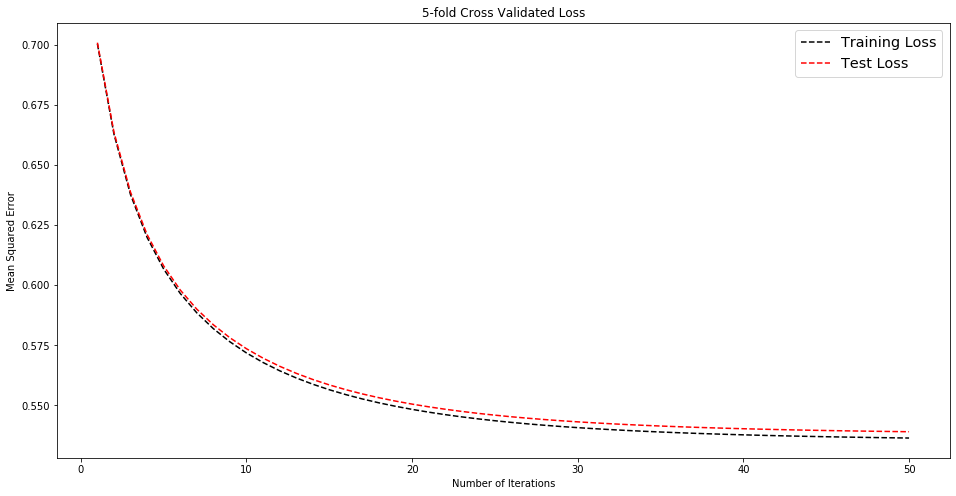

In [0]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(trainLoss, testLoss, title = '5-fold Cross Validated Loss' )

# Question 7: Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are \\(2^{p}\\) potential models that can be built from \\(p\\) features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. In this question you will implement Gradient Descent with ridge and lasso regularization.

__`IMPORTANT NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calcultion (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).

### Q7 Tasks:
* __a) short response:__ The regularization term for ridge regression is the square of the \\(L2\\) norm of the weights vector (i.e. the sum of squares of the coefficients) times the regularization parameter, \\(\lambda\\). Write the formulas for both the loss function and the gradient for Ridge Regularization and explain what extra step this will add to our gradient descent algorithm.


* __b) short response:__ The regularization term for lasso regression is the \\(L1\\) norm of the weights vector (i.e. the sum of the absolute values of the coefficients) times the regularization parameter, \\(\lambda\\). Write the formulas for both the loss function and the gradient for Lasso Regularization and explain how the gradient descent update in Lasso will be different than it was in Ridge.


* __c) code:__ Fill in the first two missing code blocks in `GDUpdate_wReg()` so that this function will perform a single parameter update using \\(L2\\) regularization if the parameter `regType` is set to `ridge`, \\(L1\\) regularization if set to `lasso` and unregularized OLS otherwise.


* __d) code + short response:__ Use the provided code to train 50 iterations of ridge and lasso regression and plot the test/train error. Comment on the curves you see. Does this match your expectation?

### Q7 Student Answers:
> __a)__ __Ridge Regression__: There is very little overhead associated with adding regularization. We calculate the gradient like we do with normal OLS and after we have calculated the gradient vector we add lambda * weight vector to the gradient and then multiply with learning rate to calculate the update.

$$
\mathbf{x}' := \begin{bmatrix} \mathbf{x} \\\ 1 \end{bmatrix} , \quad \boldsymbol{\theta} := \begin{bmatrix} \mathbf{w} \\\ b \end{bmatrix}
$$
* __Loss Function__
$$
f(\boldsymbol{\theta}) = \frac{1}{n}\sum\_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'\_i - y\_i\right]^2  \ \ \ \ \ \ + \lambda\sum\_{i=1}^m (w\_{i})^2
$$
* __Gradient__
$$
\nabla\_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum\_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'\_i - y_i\right] \cdot \mathbf{x}'\_i  \ \ \ \ \ \ + 2*\lambda\cdot\mathbf{w}
$$

> __b)__ __LASSO Regression__: Lasso gradient descent is differnt in terms adding regularization. Instaed of adding the weight vector to gradinet vector we add the __sign__ of the weight vector. This means we look at the weight vector and if a value is more than 0 we convert it to +1; if the value is less than 0 we convert it to -1; and if value is 0 we leave the value as-is  
$$
\mathbf{x}' := \begin{bmatrix} \mathbf{x} \\\ 1 \end{bmatrix} , \quad \boldsymbol{\theta} := \begin{bmatrix} \mathbf{w} \\\ b \end{bmatrix}
$$
* __Loss Function__
$$
f(\boldsymbol{\theta}) = \frac{1}{n}\sum\_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'\_i - y\_i\right]^2  \ \ \ \ \ \ + \lambda\sum\_{i=1}^m |w\_{i}| 
$$
* __Gradient__
$$
\nabla\_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum\_{i=1}^{n}\left[ \boldsymbol{\theta}^T\cdot\mathbf{x}'\_i - y_i\right] \cdot \mathbf{x}'\_i  \ \ \ \ \ \ + \lambda\cdot\mathbf{sign(w)}
$$

> __d)__ Yes, we notice the Ridge regression is little better than normal OLS regression. Especially as we near 40-50 iterations we see with Ridge regression we get much little loss on the test data. The loss on test data is closer to loss on train data. The curve for Lasso was unexpected. I was hoping to get a smooth curve for the loss on the test data however comes out as little spikey. Most probably spikes are because the coefficient starts to exceed a threashhold (loss contours start to collide with the regularization constraint) and is clipped based on the constraint that we impose due to regulaization.

In [0]:
a = np.append([5, -10], BASELINE[1:])
d = [int(num/abs(num)) if num else 0 for num in a]
d

Out[166]: [1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [0]:
# part c - gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################
    initial_model = sc.broadcast(W)
    grad = augmentedData.map(lambda x: (x[0].dot(initial_model.value.dot(x[0].T) - x[1]),1)) \
                        .reduce(lambda a,b: (np.array(a[0])+np.array(b[0]), int(a[1])+int(b[1])))
    update = grad[0].dot(learningRate*2/grad[1])
    
    reg_vector = np.append([0], W[1:])
    
    if regType == 'ridge':  
      penalty = 2*regParam*learningRate*reg_vector
      new_model = W - (update + penalty) 
      #new_model = W.dot(1-(learningRate*regParam)/grad[1]) - update
    elif regType == 'lasso':
      reg = [int(num/abs(num)) if num else 0 for num in reg_vector]
      #reg = [1 if num else 0 for num in reg_vector]
      penalty = regParam*learningRate*np.array(reg)
      new_model = W - (update + penalty)       
    else:
      new_model = W - update
      
    ################## (END) YOUR CODE ####################
    return new_model

In [0]:
# part d - ridge/lasso gradient descent function
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(OLSLoss(trainRDD, model))
        test_history.append(OLSLoss(testRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [0]:
# run 50 iterations of ridge (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50, 
                                     regType='ridge', regParam = 0.05 )
print(f"\n... trained {len(ridge_results[2])} iterations in {time.time() - start} seconds")

... trained 50 iterations in 11.66810393333435 seconds

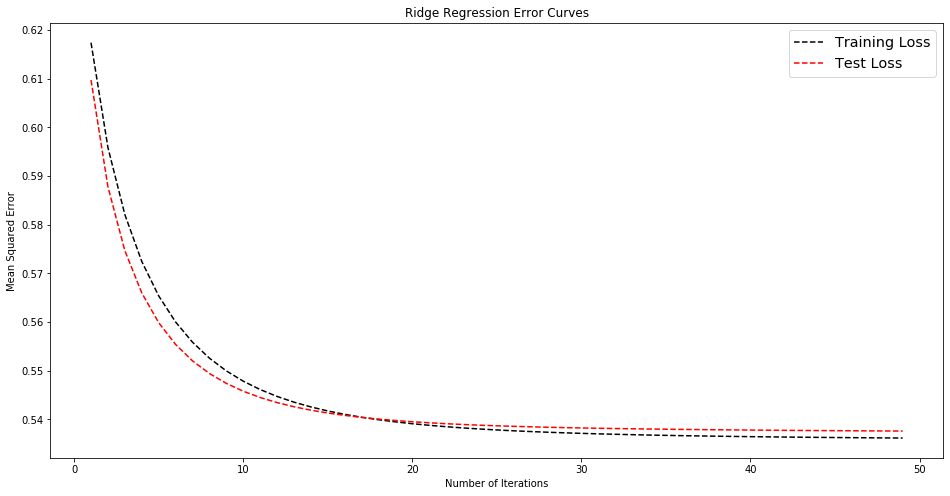

In [0]:
# part d - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = ridge_results
dbutils.fs.put(hw4_path + 'ridge_models.txt', str(models), True)
dbutils.fs.put(hw4_path + 'ridge_loss.txt', str([trainLoss, testLoss]), True)
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )

In [0]:
# run 50 iterations of lasso (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.05)
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")

... trained 50 iterations in 11.739792585372925 seconds

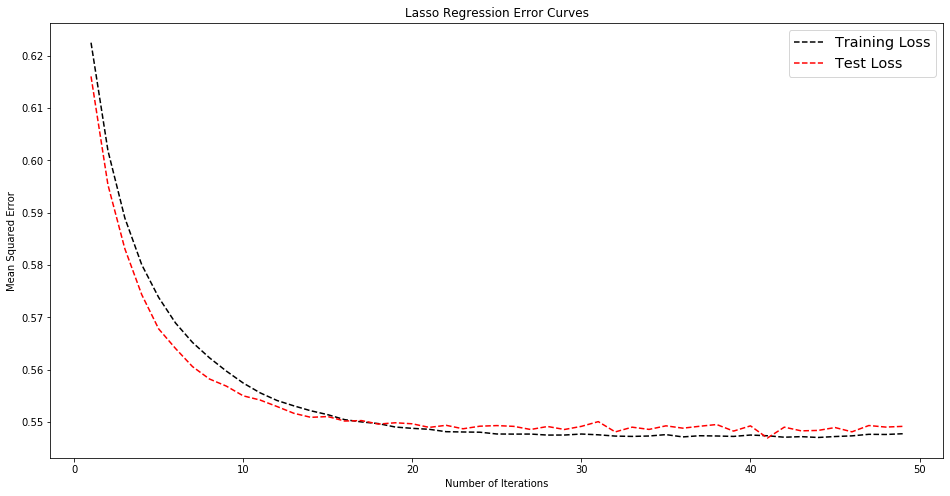

In [0]:
# part d - save and display lasso results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = lasso_results
dbutils.fs.put(hw4_path + 'lasso_models.txt', str(models), True)
dbutils.fs.put(hw4_path + 'lasso_loss.txt', str([trainLoss, testLoss]), True)
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

# Question 8: Results

In this final question we'll use a few different plots to help us compare the OLS, Ridge and Lasso models that we have trained. Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method.

### Q8 Tasks:
* __a) code:__ Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method. Then computereate a new RDD called `validationRDD` by computing the mean squared error on the held out dataset for each of the three models. [__`TIP:`__ _the held out data is in it's raw form, don't forget to parse and normalize before applying your calculations, you should also be careful to normalize using the same scaling parameters that you used for the training data._]

* __b) short response:__ Which model performed best? Discuss how you interpret these results and what you would want to try next.


* __c) short response:__ Use the provided code to plot side by side boxplots of the residuals vs. the outcome (i.e. `quality`). What can you observe about our model performance? [__`TIP:`__ _note that the heldout data set is plenty small enough to fit in memory so no need to sample. Feel free to do your plotting in pandas or any other comfortable python package._]


* __d) short response:__ Run the provided code to visualize the model coefficients for the first 50 iterations of training. What do you observe about how the OLS, ridge and lasso coefficients change over the course of the training process. Please be sure to discuss all three in your response.

### Q8 Student Answers:
> __b)__ We see OLS model performs best. I would have expected Ridge to perform best. We performed this experiment using regParam = 0.05. I would modify this hyperparameter and see if I can get better results. Thus, I would run the same experiment with various values of regParam and then pick a model that provides the lowest MSE.  

> __c)__ For low quality wines (3,4,5) our model predicts higher quality. For higher quality wines (7,8,9) our model predicts a lower quality. Our model hits the mark when the quality of wine is approx. 6.0

> __d)__ For OLS Regression, all coefficients increase or decrease over courase of the training process except coefficient for __citric_acid__. This specific coefficent start as positive  but changes direction at iteration 6 and then turns negative iteration 21. For Ridge Regression we see the coefficient behavior to be very similar to OLS except the coefficient for __citric_acid__ is driven to zero. For Lasso, all coefficient are driven to zero except __volatile_acidity__, __residual_sugar__, __free_sulphur_dioxide__, __total_sulphur_dioxide__, __sulphites__, and __alcohol__. One thing to notice in lasso regression we drive the coefficient for the __color__ variable to zero which shows color is not a prominent factor in predicting wine quality.

In [0]:
# part a - load the models from file (RUN THIS CELL AS IS)
ridge_models = open(hw4_path_open + 'ridge_models.txt', 'r').read()
lasso_models = open(hw4_path_open + 'lasso_models.txt', 'r').read()
ols_models = open(hw4_path_open + 'ols_models.txt', 'r').read()
ridge_models = np.array(ast.literal_eval(re.sub(r'[()\n]','',re.sub('array', '', ridge_models))))
lasso_models = np.array(ast.literal_eval(re.sub(r'[()\n]','',re.sub('array', '', lasso_models))))
ols_models = np.array(ast.literal_eval(re.sub(r'[()\n]','',re.sub('array', '', ols_models))))
best_ols = ols_models[-1,:]
best_ridge = ridge_models[-1,:]
best_lasso = lasso_models[-1,:]

In [0]:
best_ols

Out[174]: array([ 5.8020786095, 0.0745504535, 0.0364011329, -0.2373593506,
 -0.0184674676, 0.1609605651, -0.0418890796, 0.1044580319,
 -0.1126017622, -0.1038140706, 0.0337341856, 0.0995719625,
 0.3466690499])

In [0]:
best_ridge

Out[175]: array([ 5.8155197232, 0.061081879 , 0.0249525251, -0.2073677521,
 -0.0045551161, 0.1485618453, -0.0348005214, 0.0973046967,
 -0.1001703721, -0.106300207 , 0.030199135 , 0.1082477577,
 0.3319104622])

In [0]:
best_lasso

Out[176]: array([ 5.8158882054, -0.0003194048, 0.000424468 , -0.182118479 ,
 -0.0006934043, 0.0500107398, 0.0003000729, 0.0394992815,
 -0.0292512758, -0.0039234349, -0.000937176 , 0.0746743565,
 0.3763393793])

In [0]:
# part a - compute MSE on the held out data for all three 'best' models
olsMSE, ridgeMSE, lassoMSE = None, None, None
validationRDD = None
############### YOUR CODE HERE #################
heldOutRDDCached = heldOutRDD.map(parse).cache()
normMeans = trainRDDCached.map(lambda x: x[0]).mean()
normStdev = np.sqrt(trainRDDCached.map(lambda x: x[0]).variance())
validationRDD = heldOutRDDCached.map(lambda x: ((x[0]-normMeans)/normStdev,x[1]))

olsMSE = OLSLoss(validationRDD, best_ols)
ridgeMSE = OLSLoss(validationRDD, best_ridge)
lassoMSE = OLSLoss(validationRDD, best_lasso)
############### YOUR CODE HERE #################

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

OLS Mean Squared Error: 0.5529543649463478
Ridge Mean Squared Error: 0.554769595275707
Lasso Mean Squared Error: 0.5624143773005509

In [0]:
# part c - helper function (RUN THIS CELL AS IS)
def get_residuals(dataRDD, model):
    """
    Return a collected list of tuples (residual, quality_score)
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    residuals = augmentedData.map(lambda x: (x[1] - model.dot(x[0]), x[1]))
    return residuals.collect()

In [0]:
# part c - compute residuals for all three models (RUN THIS CELL AS IS)
ols_resid = np.array(get_residuals(validationRDD, best_ols))
ridge_resid = np.array(get_residuals(validationRDD, best_ridge))
lasso_resid = np.array(get_residuals(validationRDD, best_lasso))

In [0]:
ols_resid[:,0].mean()

Out[180]: 0.035812930194715174

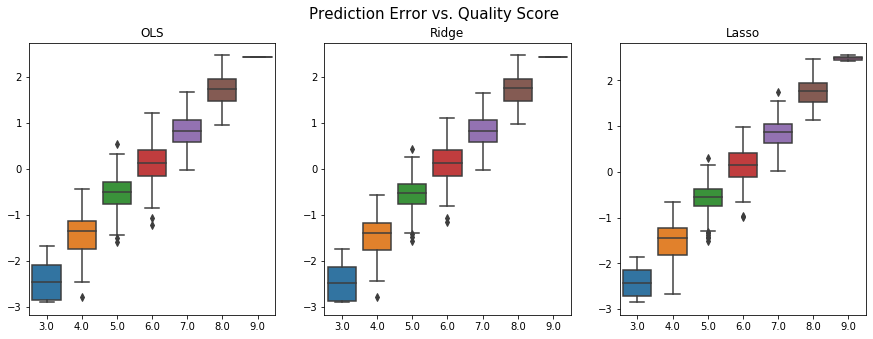

In [0]:
# part c - boxplots of residuals for all three models (RUN THIS CELL AS IS)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
stuff_to_plot = zip(axes, ["OLS", "Ridge", "Lasso"], [ols_resid, ridge_resid, lasso_resid])
for ax, title, data in stuff_to_plot:
    ax.set_title(title)
    y = data[:, 0]
    x = data[:, 1]
    sns.boxplot(x, y, ax=ax)
fig.suptitle("Prediction Error vs. Quality Score", fontsize=15, y=0.98)
display(plt.show())

In [0]:
# part d - plotting function (RUN THIS CELL AS IS)
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    display(plt.show())

In [0]:
ols_model_df = pd.DataFrame(np.array(ols_models[-50:-1,1:]), columns = FIELDS[0:12])
ridge_model_df = pd.DataFrame(np.array(ridge_models[-50:-1,1:]), columns = FIELDS[0:12])
lasso_model_df = pd.DataFrame(np.array(lasso_models[-50:-1,1:]), columns = FIELDS[0:12])

In [0]:
ols_model_df

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.018673,-0.012341,-0.044500,0.013026,-0.007733,-0.034103,0.009273,-0.009209,-0.052229,0.003484,0.007109,0.077053
1,-0.019958,-0.011536,-0.071080,0.021802,-0.006941,-0.048747,0.014557,-0.021892,-0.076432,0.007679,0.022444,0.128664
2,-0.016582,-0.007368,-0.090304,0.027719,-0.000229,-0.055981,0.020376,-0.032494,-0.087539,0.011054,0.037810,0.165343
3,-0.011932,-0.002780,-0.105506,0.031253,0.009473,-0.059911,0.026760,-0.040966,-0.092257,0.013809,0.051261,0.192894
4,-0.007021,0.001359,-0.118063,0.032855,0.020308,-0.062162,0.033229,-0.047939,-0.093817,0.016186,0.062514,0.214557
5,-0.002192,0.004864,-0.128713,0.032984,0.031262,-0.063461,0.039453,-0.053906,-0.093836,0.018302,0.071744,0.232192
6,0.002427,0.007770,-0.137922,0.032049,0.041820,-0.064163,0.045266,-0.059169,-0.093143,0.020194,0.079232,0.246913
7,0.006789,0.010180,-0.146006,0.030384,0.051744,-0.064458,0.050610,-0.063904,-0.092167,0.021871,0.085263,0.259419
8,0.010885,0.012197,-0.153193,0.028249,0.060938,-0.064458,0.055482,-0.068218,-0.091127,0.023338,0.090092,0.270176
9,0.014719,0.013910,-0.159647,0.025832,0.069386,-0.064231,0.059904,-0.072174,-0.090136,0.024603,0.093936,0.279509


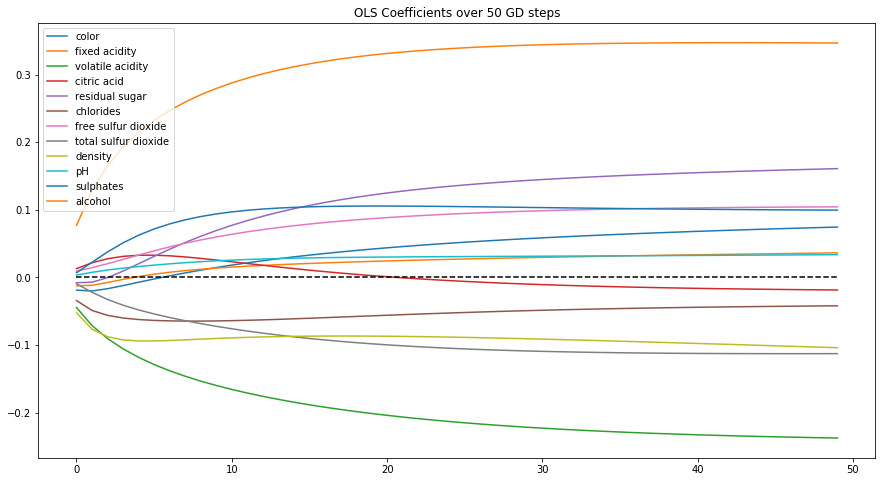

In [0]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

In [0]:
ridge_model_df

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.017538,-0.012383,-0.041874,0.014020,-0.007576,-0.031836,0.009404,-0.009022,-0.052420,0.004498,0.010541,0.078606
1,-0.018804,-0.012137,-0.066764,0.023723,-0.005466,-0.045231,0.015342,-0.020615,-0.076000,0.009095,0.027552,0.130513
2,-0.015633,-0.008674,-0.084512,0.030327,0.002459,-0.051497,0.021565,-0.030217,-0.086436,0.012676,0.043836,0.167064
3,-0.011272,-0.004853,-0.098345,0.034371,0.012983,-0.054597,0.028079,-0.037885,-0.090707,0.015505,0.057779,0.194329
4,-0.006704,-0.001490,-0.109629,0.036385,0.024247,-0.056114,0.034483,-0.044209,-0.092079,0.017843,0.069265,0.215620
5,-0.002256,0.001265,-0.119096,0.036880,0.035300,-0.056755,0.040516,-0.049627,-0.092128,0.019824,0.078567,0.232813
6,0.001956,0.003471,-0.127205,0.036296,0.045704,-0.056866,0.046065,-0.054403,-0.091621,0.021505,0.086032,0.247024
7,0.005898,0.005241,-0.134265,0.034982,0.055283,-0.056633,0.051101,-0.058692,-0.090936,0.022919,0.091990,0.258959
8,0.009568,0.006683,-0.140493,0.033202,0.063998,-0.056163,0.055642,-0.062583,-0.090252,0.024090,0.096722,0.269092
9,0.012975,0.007883,-0.146048,0.031148,0.071874,-0.055525,0.059724,-0.066133,-0.089654,0.025043,0.100462,0.277761


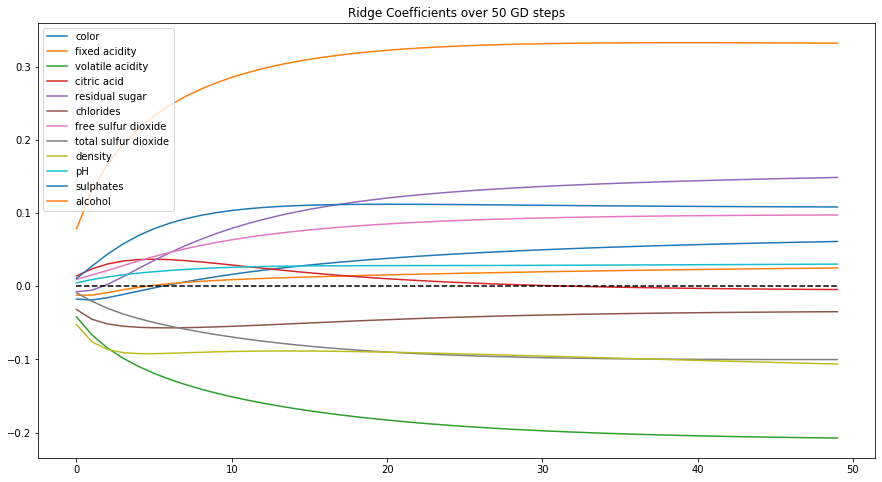

In [0]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

In [0]:
lasso_model_df

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.017538,-0.012383,-0.041874,0.014020,-0.007576,-0.031836,0.009404,-0.009022,-0.052420,0.004498,0.010541,0.078606
1,-0.013980,-0.007261,-0.062183,0.018864,-0.000542,-0.040549,0.010436,-0.015705,-0.071524,0.004140,0.022658,0.126299
2,-0.007692,-0.000793,-0.077593,0.021320,0.010864,-0.044149,0.012530,-0.020203,-0.080803,0.003760,0.034122,0.161554
3,-0.000639,0.005326,-0.090166,0.021786,0.014025,-0.045319,0.015263,-0.023021,-0.085332,0.003500,0.043944,0.189000
4,0.005837,0.000453,-0.101237,0.020994,0.019507,-0.045467,0.018989,-0.023749,-0.086438,0.002884,0.051697,0.210504
5,0.003032,-0.003293,-0.110511,0.019725,0.025506,-0.044348,0.022261,-0.024169,-0.084869,0.001807,0.058461,0.227905
6,0.002238,0.004358,-0.117409,0.017677,0.030760,-0.041759,0.024256,-0.025627,-0.081304,0.001043,0.064974,0.242484
7,0.000993,0.000452,-0.123634,0.014622,0.035726,-0.039424,0.026370,-0.026512,-0.077837,0.000708,0.069940,0.255227
8,0.000586,-0.002487,-0.128753,0.011558,0.040026,-0.036549,0.027821,-0.027783,-0.073490,0.000214,0.074439,0.266270
9,0.000373,0.005026,-0.133304,0.008576,0.043772,-0.033636,0.028993,-0.029032,-0.068816,-0.000495,0.078226,0.276044


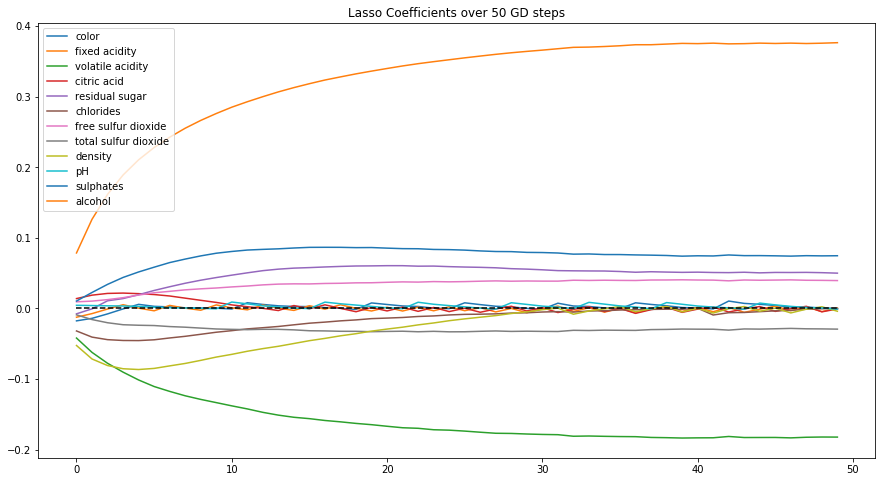

In [0]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

### Congratulations, you have completed HW4! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform